In [1]:
# Import libraries needed
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from io import BytesIO
import pydotplus as pdp

# Make results reproducible
np.random.seed(0)

# bug fix for display formats to avoid run time errors
pd.set_option('display.float_format', lambda x:'%.2f'%x)

df = pd.read_csv('gapminder.csv')

# convert to numeric format
df['incomeperperson'] = pd.to_numeric(df['incomeperperson'], errors='coerce')
df['polityscore'] = pd.to_numeric(df['polityscore'], errors='coerce')
df['urbanrate'] = pd.to_numeric(df['urbanrate'], errors='coerce')

# listwise deletion of missing values
subset = df[['incomeperperson', 'polityscore', 'urbanrate']].dropna()

# Summarize the data
print(subset[['incomeperperson', 'urbanrate']].describe())

       incomeperperson  urbanrate
count           155.00     155.00
mean           6604.57      55.11
std            9754.98      22.41
min             103.78      10.40
25%             576.39      36.83
50%            2221.19      57.18
75%            6661.18      71.51
max           39972.35     100.00


In [2]:
# Identify contries with a high level of income using the MAD (mean absolute deviation) method
subset['absolute_deviations'] = np.absolute(subset['incomeperperson'] - np.median(subset['incomeperperson']))
MAD = np.mean(subset['absolute_deviations'])

# This function converts the income per person absolute deviations to a high income flag
def high_income_flag(absolute_deviations):
    threshold = 3
    if (absolute_deviations/MAD) > threshold:
        return "Yes"
    else:
        return "No"
        
subset['High Income'] = subset['absolute_deviations'].apply(high_income_flag)
subset['High Income'] = subset['High Income'].astype('category')

In [3]:
# This function converts the polity score to a category
def convert_polityscore_to_category(polityscore):
    if polityscore == 10:
        return 1
    else:
        return 0

# Now we can use the function to create the new variable
subset['Is Full Democracy'] = subset['polityscore'].apply(convert_polityscore_to_category)
subset['Is Full Democracy'] = subset['Is Full Democracy'].astype('category')

In [4]:
# Bin urban rate into quartiles
subset['Urban Rate Quartile'] = pd.qcut(subset['urbanrate'], 4, labels=False)

In [5]:
#Split into training and testing sets
predictors = subset[['Is Full Democracy','Urban Rate Quartile']]
targets = subset[['High Income']]
training_data, test_data, training_target, test_target  = train_test_split(predictors, targets, test_size=.4)

#Build model on training data
classifier=DecisionTreeClassifier()
classifier=classifier.fit(training_data, training_target)

# Check how well the classifier worked
predictions=classifier.predict(test_data)
print(sk.metrics.confusion_matrix(test_target,predictions))

[[57  1]
 [ 1  3]]


In [6]:
print(sk.metrics.accuracy_score(test_target, predictions))

0.967741935484


In [7]:
print(sk.metrics.classification_report(test_target, predictions))

             precision    recall  f1-score   support

         No       0.98      0.98      0.98        58
        Yes       0.75      0.75      0.75         4

avg / total       0.97      0.97      0.97        62



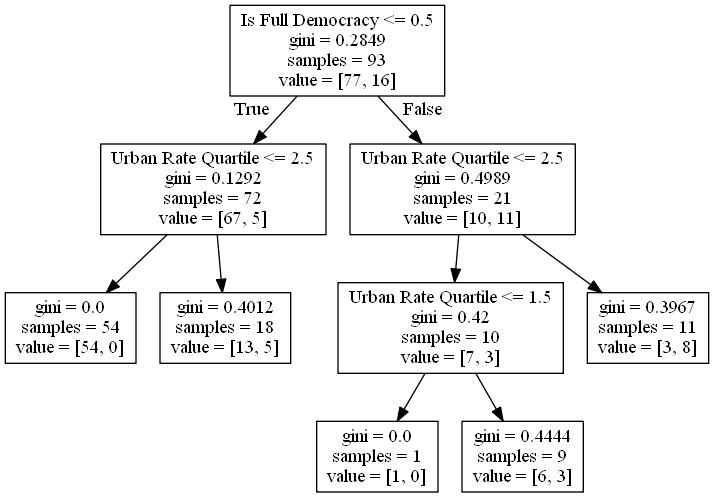

In [8]:
#Displaying the decision tree
out = BytesIO()
sk.tree.export_graphviz(classifier, out_file=out, feature_names=predictors.columns)
graph=pdp.graph_from_dot_data(out.getvalue())
Image(graph.create_png())

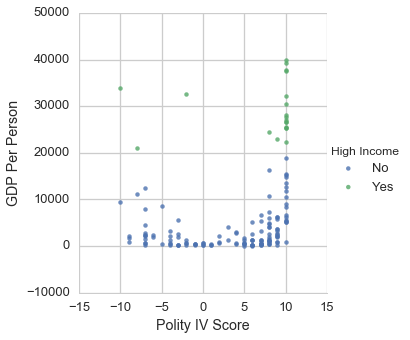

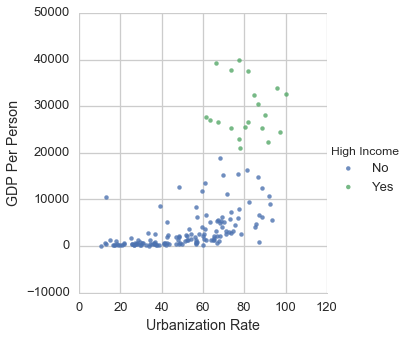

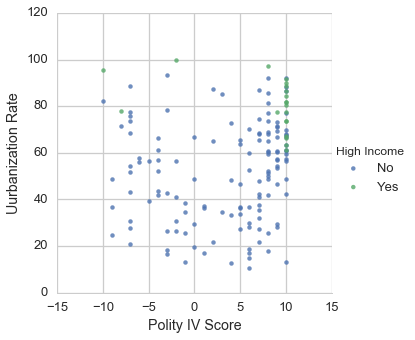

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

# Visualize the relationship
sns.lmplot(x='polityscore', y='incomeperperson', data=subset, fit_reg=False, hue='High Income')
plt.ylabel('GDP Per Person')
plt.xlabel('Polity IV Score')

# Visualize the relationship
sns.lmplot(x='urbanrate', y='incomeperperson', data=subset, fit_reg=False, hue='High Income')
plt.ylabel('GDP Per Person')
plt.xlabel('Urbanization Rate')

# Creating a visualization of the data
sns.lmplot(x='polityscore', y='urbanrate', data=subset, fit_reg=False, hue='High Income')
plt.ylabel('Uurbanization Rate')
plt.xlabel('Polity IV Score')